In [1]:
%load_ext autoreload
%autoreload 2

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import requests
from PIL import Image
from transformers import (
    AutoProcessor,
    RTDetrForObjectDetection,
    VitPoseForPoseEstimation,
)
from utils.keypoints import get_gaussian_scoremap

/Users/johncao/miniconda3/envs/cs224G_techpack_ai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Person #0
 - Nose: x=301.91, y=138.43, score=1.00
 - L_Eye: x=316.26, y=127.10, score=0.98
 - R_Eye: x=289.69, y=123.57, score=0.98
 - L_Ear: x=331.74, y=138.29, score=0.94
 - R_Ear: x=269.09, y=132.25, score=1.00
 - L_Shoulder: x=347.32, y=220.87, score=0.95
 - R_Shoulder: x=230.49, y=219.80, score=0.97
 - L_Elbow: x=376.68, y=318.87, score=0.96
 - R_Elbow: x=241.20, y=333.86, score=0.94
 - L_Wrist: x=269.16, y=309.96, score=1.03
 - R_Wrist: x=333.83, y=315.19, score=0.80
 - L_Hip: x=330.87, y=437.00, score=0.94
 - R_Hip: x=244.91, y=434.29, score=0.89
 - L_Knee: x=365.72, y=602.07, score=0.96
 - R_Knee: x=251.17, y=608.85, score=1.00
 - L_Ankle: x=424.93, y=766.44, score=0.95
 - R_Ankle: x=257.38, y=774.80, score=0.94


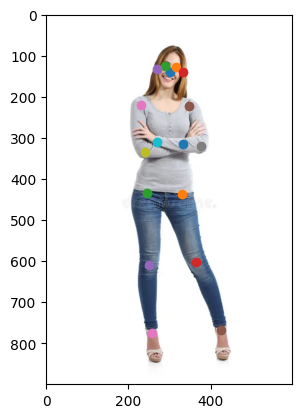

In [123]:
device = "cuda" if torch.cuda.is_available() else "cpu"
url = "http://images.cocodataset.org/val2017/000000000139.jpg"
# image = Image.open(requests.get(url, stream=True).raw)
image = Image.open('person.png')

# ------------------------------------------------------------------------
# Stage 1. Detect humans on the image
# ------------------------------------------------------------------------

# You can choose detector by your choice
person_image_processor = AutoProcessor.from_pretrained("PekingU/rtdetr_r50vd_coco_o365")
person_model = RTDetrForObjectDetection.from_pretrained("PekingU/rtdetr_r50vd_coco_o365")

inputs = person_image_processor(images=image, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = person_model(**inputs)

results = person_image_processor.post_process_object_detection(
    outputs, target_sizes=torch.tensor([(image.height, image.width)]), threshold=0.3
)
result = results[0]  # take first image results

# Human label refers 0 index in COCO dataset
person_boxes = result["boxes"][result["labels"] == 0]
person_boxes = person_boxes.cpu().numpy()

# Convert boxes from VOC (x1, y1, x2, y2) to COCO (x1, y1, w, h) format
person_boxes[:, 2] = person_boxes[:, 2] - person_boxes[:, 0]
person_boxes[:, 3] = person_boxes[:, 3] - person_boxes[:, 1]

# ------------------------------------------------------------------------
# Stage 2. Detect keypoints for each person found
# ------------------------------------------------------------------------

image_processor = AutoProcessor.from_pretrained("usyd-community/vitpose-base-simple")
model = VitPoseForPoseEstimation.from_pretrained("usyd-community/vitpose-base-simple")

inputs = image_processor(image, boxes=[person_boxes], return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)

pose_results = image_processor.post_process_pose_estimation(outputs, boxes=[person_boxes], threshold=0.3)
image_pose_result = pose_results[0]  # results for first image

fig = plt.figure()
plt.imshow(image)
for i, person_pose in enumerate(image_pose_result):
    print(f"Person #{i}")
    for keypoint, label, score in zip(
        person_pose["keypoints"], person_pose["labels"], person_pose["scores"]
    ):
        keypoint_name = model.config.id2label[label.item()]
        x, y = keypoint
        print(f" - {keypoint_name}: x={x.item():.2f}, y={y.item():.2f}, score={score.item():.2f}")
        plt.scatter(x,y)
plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


torch.Size([1, 3, 256, 192])


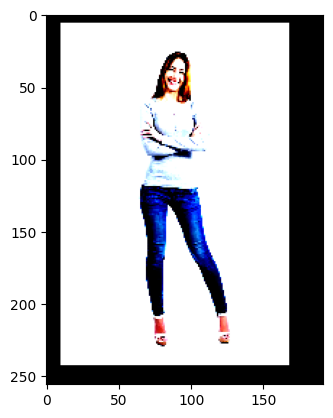

In [127]:
print(inputs['pixel_values'].shape)
im = inputs['pixel_values'].permute(0,2,3,1)
plt.imshow(im[0])

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9831932762837303..2.6399999999999997].


(256, 192, 3)


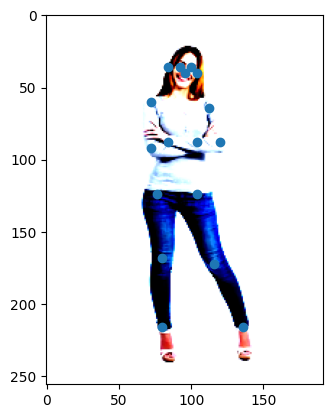

In [146]:
def normalize_image(image: Image.Image):
    """
    Normalizes a PIL image using the given mean and standard deviation.
    
    Args:
        image (PIL.Image.Image): The input image.
    
    Returns:
        np.ndarray: The normalized image as a NumPy array.
    """
    # Convert image to NumPy array (scale to [0,1])
    image_array = np.array(image).astype(np.float32) / 255.0

    # Define mean and standard deviation
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Normalize (broadcasting across channels)
    normalized_image = (image_array - mean) / std

    return normalized_image

def extract_keypoints_from_heatmap(heatmap):
    """
    Extracts keypoint coordinates from predicted heatmaps.

    Args:
        heatmap: Tensor of shape (N_k, H, W)

    Returns:
        keypoints: List of (x, y) keypoints
    """
    N_k, H, W = heatmap.shape
    keypoints = []
    for i in range(N_k):
        # Get index of max value in heatmap
        idx = torch.argmax(heatmap[i])
        y, x = divmod(idx.item(), W)  # Convert to (y, x) coordinates
        keypoints.append((x, y))

    return keypoints

normalized_image = normalize_image(image.resize([192,256]))
x = torch.tensor(normalized_image).permute(2,0,1).unsqueeze(0).float()
print(normalized_image.shape)
out = model(x)
kpts = extract_keypoints_from_heatmap(out['heatmaps'][0])

kpts_list = []
for kp in kpts:
    kpts_list.append([kp[0], kp[1]])

kpts = np.array(kpts_list)*4

fig = plt.figure()
plt.imshow(normalized_image)
plt.scatter(x=kpts[:,0], y=kpts[:,1])
plt.show()

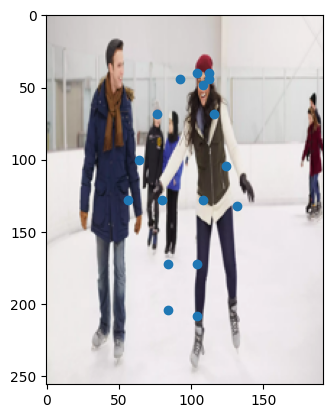

In [114]:
def extract_keypoints_from_heatmap(heatmap):
    """
    Extracts keypoint coordinates from predicted heatmaps.

    Args:
        heatmap: Tensor of shape (N_k, H, W)

    Returns:
        keypoints: List of (x, y) keypoints
    """
    N_k, H, W = heatmap.shape
    keypoints = []

    for i in range(N_k):
        # Get index of max value in heatmap
        idx = torch.argmax(heatmap[i])

        y, x = divmod(idx.item(), W)  # Convert to (y, x) coordinates
        keypoints.append((x, y))

    return keypoints

map = outputs.heatmaps[0]
image = image.resize([192,256])
kpts = extract_keypoints_from_heatmap(map)
kpts_list = []
for kp in kpts:
    kpts_list.append([kp[0], kp[1]])

kpts = np.array(kpts_list)*4

fig = plt.figure()
plt.imshow(image)
plt.scatter(x=kpts[:,0], y=kpts[:,1])
plt.show()

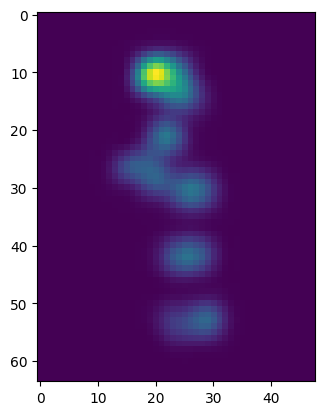

In [57]:
heatmap = torch.sum(map, dim=0)
fig = plt.figure()
plt.imshow(heatmap)
plt.show()

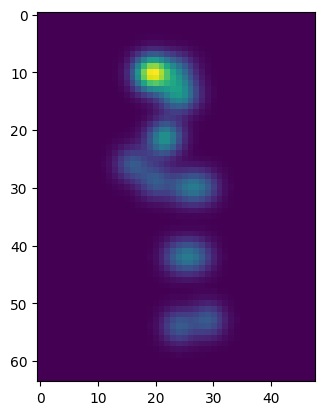

In [64]:
points = kpts/4
fig = plt.figure()
score_map_all = 0
for i in range(17):
    score_map = get_gaussian_scoremap((64,48), points[i], sigma=2)
    score_map_all += score_map
plt.imshow(score_map_all)
plt.show()

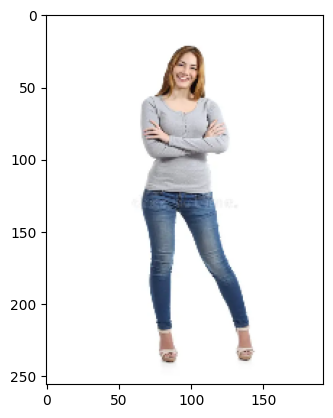

In [84]:
image = cv2.imread('person.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_orig = cv2.resize(image,[192,256])
fig = plt.figure()
plt.imshow(image_orig)
plt.show()
image = torch.from_numpy(np.array(image_orig)).permute(2,0,1).unsqueeze(0).float()